In [192]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

In [200]:
from helpers import clean_data, group_data, prep_ML, normalize
dfc = clean_data(df)
dfg = group_data(dfc)
X_p,y_possible = prep_ML(dfg)
X = normalize(X_p, None)
# We use our best version of the previous part.
label_true = ((y_possible['rater1'] + y_possible['rater2']) / 2 <= 0.5).values

First let's try the k-means algorithm with 2 clusters and print out the silhouette score:

In [204]:
from sklearn.cluster import KMeans

FYI: n_jobs = 1 because the parallel version of k-means doesn't work on OSX.

In [231]:
km = KMeans(n_clusters=2, max_iter=600, init="k-means++", n_jobs=1 )

In [232]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [233]:
labels = km.labels_
s1 = metrics.silhouette_score(X, labels, metric='euclidean')
print("s1 =", s1)

s1 = 0.520182286269


In [234]:
def test_km(X):
    km = KMeans(n_clusters=2, max_iter=600, init="k-means++", n_jobs=1 )
    km.fit(X)
    labels = km.labels_
    return metrics.silhouette_score(X, labels, metric='euclidean')

We know that the most valuable feature is the mean_Exp therefore we will remove it (just for fun)

In [253]:
from helpers import compute_feature_importance_rfc

compute_feature_importance_rfc(X, label_true)

[('seExp', 0.088973380200728966),
 ('ties', 0.045646726550477142),
 ('position', 0.038502399703503609),
 ('meanIAT', 0.087322729859908549),
 ('defeats', 0.05476869737878147),
 ('leagueCountry', 0.020459571166992097),
 ('meanExp', 0.10320126324422255),
 ('seIAT', 0.12163317198856426),
 ('yellowCards', 0.043875796337153487),
 ('victories', 0.058913554647997093),
 ('yellowReds', 0.024560016381577149),
 ('redCards', 0.02675201077705083),
 ('games', 0.05680591192244025),
 ('club', 0.058962909636232651),
 ('height', 0.05510771819238891),
 ('goals', 0.072893171761770958),
 ('weight', 0.041620970250210054)]

In [254]:
X2 = X.drop("meanExp", axis=1)
s2 = test_km(X2)
print("s2 =", s2)
print("s2 - s1 =", s2 - s1)

s2 = 0.520182515253
s2 - s1 = 2.28984719408e-07


We have a better result... that's fun !

Ok now let's remove a second feature, we will follow the same intuition as before and remove the second best feature, the club information.

In [255]:
# we know from before that the mean_Exp and goal information is at position 8, and 7 respectively in the X array
X3 = X.drop(["meanExp", "goals"], axis=1)
s3 = test_km(X3)
print("s3 =", s3)
print("s3 - s1 =", s3 - s1)
print("s3 - s2 =", s3 - s2)

s3 = 0.534763979031
s3 - s1 = 0.0145816927624
s3 - s2 = 0.0145814637777


There is an even better improvement

In [256]:
# we now remove seExp in addition to the other 2 (3rd best feature)
X4 = X.drop(["meanExp", "goals", "seIAT"], axis=1)
s4 = test_km(X4)
print("s4 =", s4)
print("s4 - s1 =", s4 - s1)
print("s4 - s2 =", s4 - s2)
print("s4 - s3 =", s4 - s3)

s4 = 0.534763979043
s4 - s1 = 0.0145816927747
s4 - s2 = 0.0145814637899
s4 - s3 = 1.2266077043e-11


To see whether the clustering is close to a dark/light separation we will compute in addition to the silhouerre the accuracy score 

In [306]:
def scoring_complete(X):
    km = KMeans(n_clusters=2, max_iter=300, init="k-means++", n_jobs=1 )
    km.fit(X)
    labels = km.labels_
    print("silhouette score :", metrics.silhouette_score(X, labels, metric='euclidean'))
    print("closeness to true label score :", metrics.adjusted_mutual_info_score(label_true, labels))

scoring_complete(X)

silhouette score : 0.520182286269
closeness to true label score : 0.00148503518648


We have a very low closeness score but at least it's positive.

In [307]:
scoring_complete(X2)

silhouette score : 0.520182515253
closeness to true label score : 0.00148503518648


Here we see that eventhough the silhouette score is better our label accuracy is the same as before.

Other example :

In [308]:
scoring_complete(X3)

silhouette score : 0.534763979031
closeness to true label score : 0.00139343315139


In [309]:
scoring_complete(X4)

silhouette score : 0.534763979043
closeness to true label score : 0.00139343315139


Clearly here we are changinging the biais of the clustering algorithm (with respect to our "true" labels) **TODO : verify this !**

Now let's remove the worse features for example the red / yellow / redYellow / cards (not all are the absolute worst but they were all in the < 0.05 importance in the previous exercice.)

rows : 8, 10, 11

In [310]:
X5 =  X.drop(["yellowReds", "redCards", "yellowCards"], axis=1)
scoring_complete(X5)

silhouette score : 0.525815015218
closeness to true label score : 0.00153154185275


We have good results ! the silhouette is good and closeness has improved.

Let's now remove all the features that have the worst feature importance until our closeness score drops significantly

In [316]:
compute_feature_importance_rfc(X5, label_true)

[('seExp', 0.090734517847413904),
 ('ties', 0.059222937328914656),
 ('position', 0.047220349142919622),
 ('meanIAT', 0.094221319973384274),
 ('defeats', 0.062435089482637873),
 ('leagueCountry', 0.021643719152949905),
 ('meanExp', 0.11018392687581169),
 ('seIAT', 0.11980901160558134),
 ('victories', 0.072661383575704147),
 ('games', 0.065555128674252575),
 ('club', 0.069533231970040521),
 ('height', 0.050464006558890356),
 ('goals', 0.080149359970852221),
 ('weight', 0.056166017840646933)]

In [336]:
X6 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height"], axis=1)
scoring_complete(X6)

silhouette score : 0.527552347322
closeness to true label score : 0.00153154185275


In [338]:
compute_feature_importance_rfc(X6, label_true)

[('seExp', 0.099660458637477828),
 ('ties', 0.066580093568056595),
 ('meanIAT', 0.10847463368789703),
 ('defeats', 0.063663673392746367),
 ('meanExp', 0.13648033820626368),
 ('seIAT', 0.13192620116349682),
 ('victories', 0.094932958035951809),
 ('games', 0.06966435196777554),
 ('club', 0.083280640760261163),
 ('goals', 0.082393859452367227),
 ('weight', 0.062942791127705983)]

In [339]:
X7 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height", "weight"], axis=1)
scoring_complete(X7)

silhouette score : 0.529022900697
closeness to true label score : 0.00153154185275


In [341]:
compute_feature_importance_rfc(X7, label_true)

[('seExp', 0.11734933947022269),
 ('ties', 0.077704227818589711),
 ('meanIAT', 0.13331410315486925),
 ('defeats', 0.06488856867816914),
 ('meanExp', 0.13607890155277488),
 ('seIAT', 0.14181569544766426),
 ('victories', 0.088031176742450187),
 ('games', 0.073320588506865361),
 ('club', 0.077961380995067553),
 ('goals', 0.089536017633326984)]

In [342]:
X8 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height", "weight", "defeats"], axis=1)
scoring_complete(X8)

silhouette score : 0.536964515555
closeness to true label score : 0.00167489477223


In [343]:
compute_feature_importance_rfc(X8, label_true)

[('seExp', 0.11390124343601513),
 ('ties', 0.080360079068860307),
 ('meanIAT', 0.12929154452660913),
 ('meanExp', 0.14808915884301269),
 ('seIAT', 0.1615364154812565),
 ('victories', 0.10041000330136582),
 ('games', 0.082400059224432304),
 ('club', 0.082262699770286857),
 ('goals', 0.10174879634816122)]

In [344]:
X9 =  X.drop(["yellowReds", "redCards", "yellowCards", "position", "leagueCountry", "height", "weight", "defeats", "ties"], axis=1)
scoring_complete(X9)

silhouette score : 0.54100299212
closeness to true label score : 0.00117917185045


We stop here as we have the worst result.

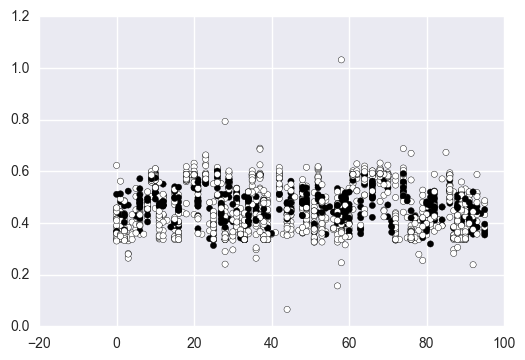

In [349]:
plt.scatter(X8["club"], X8["meanExp"], c=labels)